<a href="https://colab.research.google.com/github/RefenRefen/hidden-rep/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

import pickle

from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, Dropout
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential, Model
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpy import array
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

tfd = tfp.distributions
tfpl = tfp.layers

# Loading Data

In [3]:
# df = pd.read_csv('https://query.data.world/s/acygrvxfgqb76o7mqo4igj4gzahxbw?dws=00000')
# df.to_csv('./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/data/airlinedelaycauses_DelayedFlights.csv')

In [4]:
# df.head()

In [5]:
# !pwd

In [6]:
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/data/airlinedelaycauses_DelayedFlights.csv')

In [7]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Year', 'Month', 'DayofMonth',
       'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode',
       'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')

In [8]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [9]:
df.sort_values(by=['Month', 'DayofMonth', 'DayOfWeek', 'DepTime'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [10]:
df

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,1,2,1.0,1950,228.0,2235,WN,106,...,3.0,7.0,0,N,0,151.0,0.0,0.0,0.0,82.0
1,2008,1,1,2,1.0,2135,117.0,2300,WN,3558,...,5.0,9.0,0,N,0,51.0,0.0,0.0,0.0,86.0
2,2008,1,1,2,2.0,2355,529.0,532,F9,380,...,7.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,1,2,2.0,2255,57.0,2357,FL,579,...,8.0,9.0,0,N,0,0.0,0.0,0.0,0.0,60.0
4,2008,1,1,2,2.0,2355,836.0,755,B6,166,...,8.0,34.0,0,N,0,7.0,0.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,2008,12,31,3,2347.0,2325,1005.0,950,AA,254,...,6.0,16.0,0,N,0,15.0,0.0,0.0,0.0,0.0
1936754,2008,12,31,3,2350.0,2336,737.0,705,UA,86,...,10.0,20.0,0,N,0,0.0,0.0,32.0,0.0,0.0
1936755,2008,12,31,3,2355.0,2315,645.0,621,DL,952,...,5.0,11.0,0,N,0,24.0,0.0,0.0,0.0,0.0
1936756,2008,12,31,3,2356.0,1925,253.0,2234,NW,245,...,8.0,15.0,0,N,0,259.0,0.0,0.0,0.0,0.0


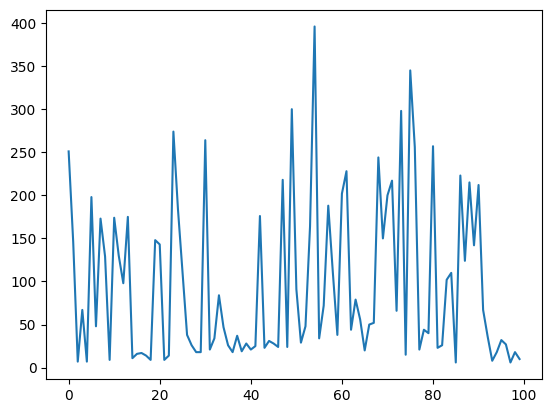

In [11]:
plt.plot(df.DepDelay[:100])

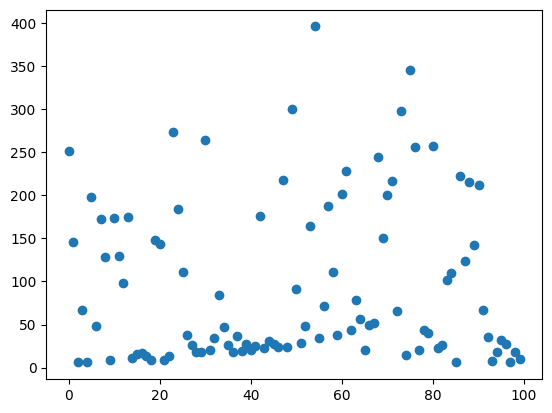

In [12]:
plt.scatter(df.index[:100], df.DepDelay[:100])

In [13]:
# list(df.groupby(['Month', 'DayOfWeek']))

<BarContainer object of 7 artists>

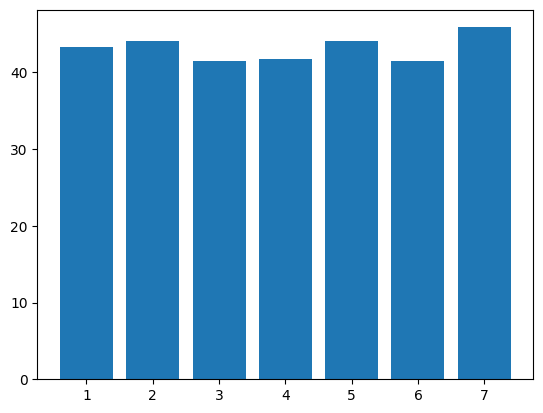

In [14]:
plt.bar(df.groupby('DayOfWeek')['DepDelay'].mean().index, df.groupby('DayOfWeek')['DepDelay'].mean())

<BarContainer object of 31 artists>

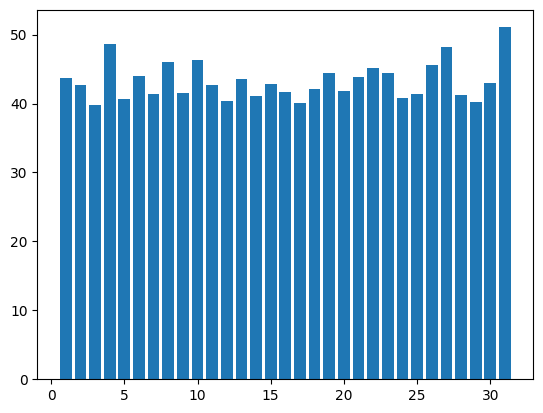

In [15]:
plt.bar(df.groupby('DayofMonth')['DepDelay'].mean().index, df.groupby('DayofMonth')['DepDelay'].mean())

In [16]:
df[df['DepDelay']>120].shape[0] / df.shape[0] * 100

7.194239032444942

In [17]:
9836 / df.shape[0] * 100

0.5078590097472168

In [18]:
# # Time step detector
# step_list = []
# i = 0
# for row in range(df.shape[0]):
#     if df.loc[row]['DepDelay'] > 120:
#         step_list.append(i)
#         i = 0
#     else:
#         i += 1

In [19]:
# np.mean(step_list)

In [20]:
data = df[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'DepDelay']].copy()

In [21]:
data['DepDelay'].mean()

43.185176464999756

In [22]:
# df['gender'].mask(df['gender'] == 'female', 0, inplace=True)
delay_mean = np.round(data['DepDelay'].mean())
data['DepDelay'].mask(data['DepDelay'] > 120, delay_mean, inplace=True)

Data Scaling

In [23]:
scaler = MinMaxScaler(feature_range=(0.1, 1.1))
scaler.fit(data)
transformed_matrix = scaler.transform(data)

transformed_data = pd.DataFrame(data=transformed_matrix.round(3), columns=data.columns)

In [24]:
# transformed_data['DayofMonth'].unique()

In [25]:
# def split_sequence(sequence, n_steps_in, n_steps_out):
#   X, y = list(), list()
#   for i in range(len(sequence)):
#     # find the end of this pattern
#     end_ix = i + n_steps_in
#     out_end_ix = end_ix + n_steps_out
#     # check if we are beyond the sequence
#     if out_end_ix > len(sequence):
#       break
#     # gather input and output parts of the pattern
#     seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
#     X.append(seq_x)
#     y.append(seq_y)
#   return array(X), array(y)

In [26]:
def timeseries_3d_maker(data:pd.DataFrame, step_in:int, step_out:int):
    # Takes a pandas dataframe as input and create output 3D timeseries for LSTM layers

    x_matrix = []
    y_matrix = []
    for i in range(data.shape[0]):
        temp_matrix = []
        temp_y_matrix = []
        red_flag = 0
        for j in range(0, step_in):
            if i+step_in >= data.shape[0]:
                red_flag = 1
                break
            temp_matrix.append(list(data.loc[i+j]))

        for k in range(step_out):
            if i+step_in+step_out >= data.shape[0]:
                red_flag = 1
                break
            else:
                temp_y_matrix.append([data.loc[i+step_in+k]['DepDelay']])

        if red_flag == 1 or len(temp_matrix)<step_in:
            break

        x_matrix.append(temp_matrix)
        y_matrix.append(temp_y_matrix)
    return array(x_matrix), array(y_matrix)


In [27]:
# dummy_df = data[:100].copy()
# dummy_df.head(10)

In [28]:
transformed_data.head()

,Month,DayofMonth,DayOfWeek,DepTime,DepDelay
0,0.1,0.1,0.267,0.1,0.425
1,0.1,0.1,0.267,0.1,0.425
2,0.1,0.1,0.267,0.1,0.109
3,0.1,0.1,0.267,0.1,0.635
4,0.1,0.1,0.267,0.1,0.109


In [29]:
step_in = 7
step_out = 1
n_features = 5

In [30]:
# X, y = timeseries_3d_maker(transformed_data, step_in, step_out)

In [31]:
# with open(f'./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/data/X_{step_in}_{step_out}.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(X, file)

In [32]:
# with open(f'./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/data/y_{step_in}_{step_out}.pkl', 'wb') as file:
#     # A new file will be created
    # pickle.dump(y, file)

In [33]:
with open(f'./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/data/X_{step_in}_{step_out}.pkl', 'rb') as file:
    # Call load method to deserialze
    X = pickle.load(file)

with open(f'./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/data/y_{step_in}_{step_out}.pkl', 'rb') as file:
    # Call load method to deserialze
    y = pickle.load(file)

In [34]:
X.shape[0] * 0.7

1355725.0

In [35]:
train_perc = int(X.shape[0] * 0.7)
valid_perc = int(X.shape[0] * 0.9)

X_train = X[:train_perc]
y_train = y[:train_perc]

X_valid = X[train_perc:valid_perc]
y_valid = y[train_perc:valid_perc]

X_test = X[valid_perc:]
y_test = y[valid_perc:]

In [36]:
print(X_test.shape)
print(X_test.shape)

(193675, 7, 5)
(193675, 7, 5)


In [37]:
# print(X[:5])
# print(y[:5])
# print(len(X))
# print(len(y))

# Model

In [38]:
print(tf.__version__)

2.15.0


Distributions

In [39]:
# Define the prior weight distribution --all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  prior_model = Sequential([
                            tfpl.DistributionLambda(
                                lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
                            )
  ])
  return prior_model

In [40]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = Sequential([
                                tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
                                tfpl.MultivariateNormalTriL(n)
  ])
  return posterior_model

In [41]:
# def get_model(n_steps_in, n_features):

#   model = Sequential()
#   model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
#   model.add(RepeatVector(step_out))
#   model.add(LSTM(100, activation='relu', return_sequences=True))
#   model.add(tfpl.DenseVariational(input_shape=(3,),
#                                             units=3,
#                                             make_prior_fn=prior,
#                                             make_posterior_fn=posterior,
#                                             kl_weight=1/X.shape[0],
#                                             kl_use_exact=True))
#   model.add(TimeDistributed(Dense(1)))
#   model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#   return model

In [117]:
def get_model(n_steps_in, n_features):

  model = Sequential()
  model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#   model.add(Dropout(0.2))
  model.add(LSTM(64, activation='relu', return_sequences=True))
#   model.add(Dropout(0.2))
  model.add(LSTM(32, activation='relu', return_sequences=True))
#   model.add(Dropout(0.2))
  model.add(LSTM(32, activation='relu', return_sequences=False ))
#   model.add(Dropout(0.2))
#   model.add(tfpl.DenseVariational(units=8,
#                                             make_prior_fn=prior,
#                                             make_posterior_fn=posterior,
#                                             kl_weight=1/100,
#                                             kl_use_exact=True))
#   model.add(tfpl.DenseVariational(units=4,
#                                             make_prior_fn=prior,
#                                             make_posterior_fn=posterior,
#                                             kl_weight=1/100,
#                                             kl_use_exact=True))
#   model.add(tfpl.DenseVariational(units=2,
#                                             make_prior_fn=prior,
#                                             make_posterior_fn=posterior,
#                                             kl_weight=1/100,
#                                             kl_use_exact=True))
#   model.add(Dense(4))
  model.add(tfpl.DenseVariational(units=1,
                                            make_prior_fn=prior,
                                            make_posterior_fn=posterior,
                                            kl_weight=1/100,
                                            kl_use_exact=True))
#   model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

In [118]:
nn_model = get_model(step_in, n_features)
nn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 7, 64)             17920     
                                                                 
 lstm_21 (LSTM)              (None, 7, 64)             33024     
                                                                 
 lstm_22 (LSTM)              (None, 7, 32)             12416     
                                                                 
 lstm_23 (LSTM)              (None, 32)                8320      
                                                                 
 dense_variational_14 (Dens  (None, 1)                 594       
 eVariational)                                                   
                                                                 
Total params: 72274 (282.32 KB)
Trainable params: 72274 (282.32 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [119]:
num_epoch = 120
nn_history = nn_model.fit(X_train[:100], y_train[:100], batch_size=2, #validation_data=(X_valid, y_valid),
                            epochs=num_epoch,
                            verbose=1)

Epoch 1/120
50/50 [==============================] - 6s 18ms/step - loss: 0.5161 - mae: 0.5283
Epoch 2/120
50/50 [==============================] - 1s 17ms/step - loss: 0.5648 - mae: 0.6036
Epoch 3/120
50/50 [==============================] - 1s 16ms/step - loss: 0.6753 - mae: 0.5723
Epoch 4/120
50/50 [==============================] - 1s 17ms/step - loss: 0.7453 - mae: 0.6659
Epoch 5/120
50/50 [==============================] - 1s 17ms/step - loss: 0.5962 - mae: 0.6529
Epoch 6/120
50/50 [==============================] - 1s 11ms/step - loss: 0.4006 - mae: 0.4885
Epoch 7/120
50/50 [==============================] - 1s 11ms/step - loss: 0.4307 - mae: 0.5130
Epoch 8/120
50/50 [==============================] - 1s 11ms/step - loss: 0.5584 - mae: 0.5991
Epoch 9/120
50/50 [==============================] - 1s 10ms/step - loss: 0.3782 - mae: 0.4850
Epoch 10/120
50/50 [==============================] - 1s 11ms/step - loss: 0.3256 - mae: 0.4573
Epoch 11/120
50/50 [=============================

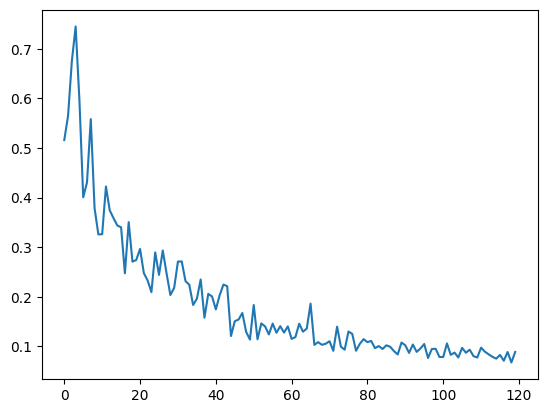

In [120]:
plt.plot(nn_history.history['loss'])

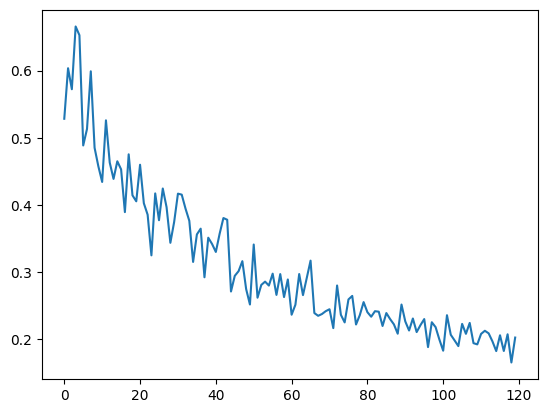

In [121]:
plt.plot(nn_history.history['mae'])

In [ ]:
nn_model.save_weights('./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/models/SBNN_Weights.hdf5')


In [ ]:
nn_model = get_model(step_in, n_features)
nn_model.load_weights('./drive/MyDrive/Colab Notebooks/Foad/courses/Probabilistic Learning/project/models/SBNN_Weights.hdf5')

In [101]:
nn_model.predict(X_train[:10])

1/1 [==============================] - 1s 820ms/step


array([[0.52527213],
       [0.52526623],
       [0.52526134],
       [0.5252866 ],
       [0.5252609 ],
       [0.5252847 ],
       [0.52528346],
       [0.5252825 ],
       [0.52528626],
       [0.5252883 ]], dtype=float32)

In [102]:
y_train[:10]

array([[[0.425]],

       [[0.425]],

       [[0.126]],

       [[0.425]],

       [[0.425]],

       [[0.907]],

       [[0.425]],

       [[0.144]],

       [[0.188]],

       [[0.196]]])

In [122]:
pred_matrix = [list(nn_model.predict(X_test[:100], batch_size=1, verbose=0).flatten()) for i in range(50)]
pred_matrix = array(pred_matrix)

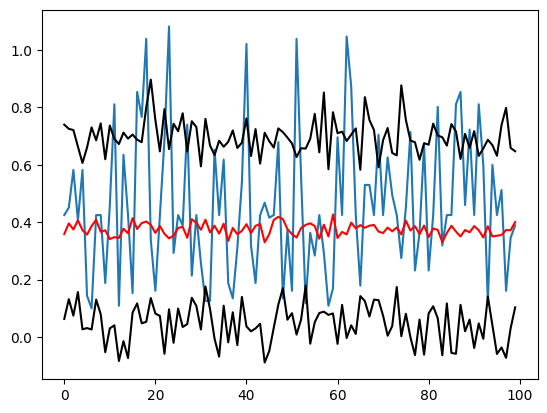

In [124]:
plt.plot(y_test[:100].flatten())
plt.plot(pred_matrix.mean(axis=0), color='r')
plt.plot(pred_matrix.max(axis=0), color='k')
plt.plot(pred_matrix.min(axis=0), color='k')

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

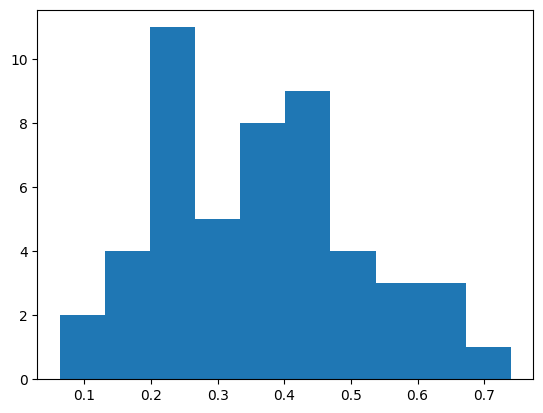

In [127]:
n = 10
plt.hist(pred_matrix[:, n], 10)
plt.bar(y_test[n])

100/100 [==============================] - 1s 7ms/step


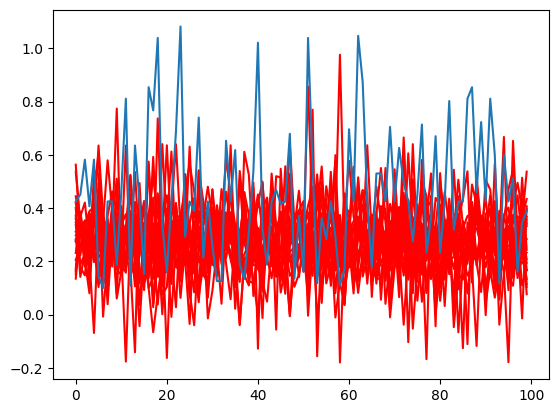

In [50]:
# y_train[:100]

for i in range(20):
    plt.plot(nn_model.predict(X_test[:100], batch_size=1).flatten(), color='red')
plt.plot(y_test[:100].flatten())

In [ ]:
nn_model.predict(X_test[:10]).flatten()

In [ ]:
nn_model.predict(X_train[:100], batch_size=100).flatten()